In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
import pandas as pd
import os
import torch
import numpy as np
import scipy.stats as st
import statsmodels.api as sm 
import math

df = pd.read_csv('data/mathwell_annotations_final.csv')
model_path = "meta-llama/Llama-2-70b-hf"   # Specify the path to the model

env_file_path = 'data/env.txt'

# Read and set environment variables
with open(env_file_path, 'r') as file:
    for line in file:
        key, value = line.strip().split('=')
        os.environ[key] = value
token = os.environ['huggingface_token']
tokenizer = AutoTokenizer.from_pretrained(model_path, token=token)

/Users/bryan/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
df = pd.read_csv('data/evaluation_annotations.csv')
df

,solvability,accuracy,appropriateness,topic,addition,subtraction,multiplication,division,fractions,decimals,...,solution,answer,gpt35,gpt4,llama,llema,mammoth,mathwell,fkgl,ndc
0,1,1.0,1.0,1,1.0,1.0,0.0,0.0,0.0,0.0,...,def solution():\n #Steph Curry has 3000 poi...,0,0,0,1,0,0,0,0.8,8.73
1,1,1.0,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0,...,def solution():\n #Number of players\n p...,30,0,0,0,0,1,0,1.0,8.10
2,1,0.0,1.0,1,0.0,0.0,0.0,1.0,0.0,1.0,...,def solution():\n #A commercial airplane ta...,0.6,0,0,1,0,0,0,4.7,8.84
3,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,def solution():\n #Raphael is 6 inches tall...,30,0,0,0,1,0,0,5.2,7.77
4,1,1.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0.0,...,def solution():\n #Spiderman needs to load ...,180,0,0,0,1,0,0,5.0,8.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,def solution():\n # Ash starts with 50 Poké...,44,0,1,0,0,0,0,3.8,9.06
1496,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,def solution():\n # Jenny has 12 cats\n ...,4,0,1,0,0,0,0,4.5,7.14
1497,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,def solution():\n # Max finds 3 sticks ever...,5,0,1,0,0,0,0,3.7,9.66
1498,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,def solution():\n # Each pyramid requires 3...,4,0,1,0,0,0,0,6.5,9.49


In [2]:
def check_mathwell(df, colname):
    question_lengths = []
    for i in range(0, len(df)):
        output = df.iloc[i][f"{colname}"]
        try: 
            inputs = tokenizer.encode(output, return_tensors="pt")
        except:
            pass
        length = inputs.shape[1]
        question_lengths.append(length)
    return np.array(question_lengths)

In [18]:
df['question_length'] = check_mathwell(df, 'question')
df['solution_length'] = check_mathwell(df, 'solution')

In [19]:
df.to_csv('data/evaluation_annotations.csv', index = False)
df = pd.read_csv('data/evaluation_annotations.csv')
df

,solvability,accuracy,appropriateness,topic,addition,subtraction,multiplication,division,fractions,decimals,...,gpt35,gpt4,llama,llema,mammoth,mathwell,fkgl,ndc,question_length,solution_length
0,1,1.0,1.0,1,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0.8,8.73,62,130
1,1,1.0,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1.0,8.10,27,57
2,1,0.0,1.0,1,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0,1,0,0,0,4.7,8.84,54,95
3,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,5.2,7.77,80,139
4,1,1.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,5.0,8.67,72,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,3.8,9.06,83,223
1496,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,4.5,7.14,65,145
1497,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,3.7,9.66,60,116
1498,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,6.5,9.49,67,172


In [23]:
df.columns.tolist()

['solvability',
 'accuracy',
 'appropriateness',
 'topic',
 'addition',
 'subtraction',
 'multiplication',
 'division',
 'fractions',
 'decimals',
 'no_ops',
 'total_ops',
 'good',
 'question',
 'solution',
 'answer',
 'gpt35',
 'gpt4',
 'llama',
 'llema',
 'mammoth',
 'mathwell',
 'fkgl',
 'ndc',
 'question_length',
 'solution_length']

In [47]:
def recode(df):
    if df['no_ops']==1:
        return 0
    else:
        return df['total_ops']
df['total_ops'] = df.apply(recode, axis=1)

In [53]:
reg_df = df[df['solvability']==1]
x = reg_df[['fkgl', 'ndc', 'question_length', 'solution_length', 'addition', 'subtraction',
       'multiplication', 'division', 'fractions', 'decimals', 'llema', 'llama', 'mammoth', 'gpt35', 'gpt4']]
x = sm.add_constant(x)
y = reg_df['accuracy']
log_reg = sm.Logit(y, x).fit() 
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.264355
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               accuracy   No. Observations:                 1229
Model:                          Logit   Df Residuals:                     1213
Method:                           MLE   Df Model:                           15
Date:                Fri, 24 May 2024   Pseudo R-squ.:                  0.1592
Time:                        10:01:47   Log-Likelihood:                -324.89
converged:                       True   LL-Null:                       -386.40
Covariance Type:            nonrobust   LLR p-value:                 4.893e-19
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.1526      0.889      4.669      0.000       2.409       5.896
fkgl               -0.0017      0.057     -0.030      0.976      -0.113       0.110
ndc                 0.0233      0.086      0.272      0.786      -0.145       0.191
question_length    -0.0042      0.005     -0.905      0.365      -0.013       0.005
solution_length    -0.0103      0.003     -4.006      0.000      -0.015      -0.005
addition            0.4493      0.249      1.803      0.071      -0.039       0.938
subtraction         0.4759      0.265      1.797      0.072      -0.043       0.995
multiplication      0.1092      0.253      0.431      0.666      -0.387       0.605
division           -0.2423      0.282     -0.858      0.391      -0.796       0.311
fractions          -0.2326      0.431     -0.539      0.590      -1.078       0.613
decimals           -0.1096      0.302     -0.363      0.717      -0.701       0.482
llema              -2.6894      0.445     -6.044      0.000      -3.562      -1.817
llama              -1.1741      0.450     -2.609      0.009      -2.056      -0.292
mammoth            -0.4270      0.505     -0.845      0.398      -1.417       0.563
gpt35              -0.8519      0.471     -1.809      0.070      -1.775       0.071
gpt4                0.6421      0.579      1.110      0.267      -0.492       1.777
===================================================================================
"""

In [58]:
reg_df = df[df['solvability']==1]
x = reg_df[['fkgl', 'ndc', 'question_length', 'solution_length', 'addition', 'subtraction',
       'multiplication', 'division', 'fractions', 'decimals']]
x = sm.add_constant(x)
y = reg_df['accuracy']
log_reg = sm.Logit(y, x).fit() 
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.301228
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               accuracy   No. Observations:                 1229
Model:                          Logit   Df Residuals:                     1218
Method:                           MLE   Df Model:                           10
Date:                Fri, 24 May 2024   Pseudo R-squ.:                 0.04191
Time:                        10:07:59   Log-Likelihood:                -370.21
converged:                       True   LL-Null:                       -386.40
Covariance Type:            nonrobust   LLR p-value:                 0.0003450
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.5607      0.758      3.379      0.001       1.075       4.046
fkgl                0.0493      0.051      0.958      0.338      -0.052       0.150
ndc                -0.0275      0.081     -0.339      0.734      -0.186       0.131
question_length    -0.0065      0.004     -1.493      0.135      -0.015       0.002
solution_length    -0.0050      0.002     -2.343      0.019      -0.009      -0.001
addition            0.6062      0.236      2.569      0.010       0.144       1.069
subtraction         0.8166      0.253      3.230      0.001       0.321       1.312
multiplication      0.5294      0.240      2.206      0.027       0.059       1.000
division            0.1781      0.269      0.663      0.507      -0.349       0.705
fractions          -0.5802      0.394     -1.474      0.140      -1.352       0.191
decimals           -0.3604      0.280     -1.287      0.198      -0.909       0.189
===================================================================================
"""

In [50]:
reg_df = df[df['solvability']==1]
x = reg_df[['fkgl', 'ndc', 'question_length', 'solution_length', 'total_ops']]
      # 'llema', 'llama', 'mammoth', 'gpt35', 'gpt4']]
x = sm.add_constant(x)
y = reg_df['accuracy']
log_reg = sm.Logit(y, x).fit() 
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.312156
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               accuracy   No. Observations:                 1229
Model:                          Logit   Df Residuals:                     1223
Method:                           MLE   Df Model:                            5
Date:                Fri, 24 May 2024   Pseudo R-squ.:                0.007152
Time:                        09:56:40   Log-Likelihood:                -383.64
converged:                       True   LL-Null:                       -386.40
Covariance Type:            nonrobust   LLR p-value:                    0.3550
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.8487      0.729      3.909      0.000       1.420       4.277
fkgl                0.0270      0.049      0.550      0.582      -0.069       0.123
ndc                -0.0512      0.077     -0.664      0.507      -0.202       0.100
question_length    -0.0049      0.004     -1.151      0.250      -0.013       0.003
solution_length    -0.0027      0.002     -1.226      0.220      -0.007       0.002
total_ops           0.2142      0.133      1.610      0.107      -0.047       0.475
===================================================================================
"""

In [51]:
reg_df = df[df['solvability']==1]
x = reg_df[['fkgl', 'ndc', 'question_length', 'solution_length', 'total_ops', 'llema', 'llama', 'mammoth', 'gpt35', 'gpt4']]
x = sm.add_constant(x)
y = reg_df['accuracy']
log_reg = sm.Logit(y, x).fit() 
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.270017
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               accuracy   No. Observations:                 1229
Model:                          Logit   Df Residuals:                     1218
Method:                           MLE   Df Model:                           10
Date:                Fri, 24 May 2024   Pseudo R-squ.:                  0.1412
Time:                        10:00:50   Log-Likelihood:                -331.85
converged:                       True   LL-Null:                       -386.40
Covariance Type:            nonrobust   LLR p-value:                 8.077e-19
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.4999      0.853      5.274      0.000       2.828       6.172
fkgl               -0.0227      0.055     -0.409      0.682      -0.131       0.086
ndc                 0.0066      0.082      0.080      0.936      -0.154       0.167
question_length    -0.0023      0.005     -0.489      0.625      -0.012       0.007
solution_length    -0.0087      0.003     -3.477      0.001      -0.014      -0.004
total_ops           0.0687      0.128      0.537      0.591      -0.182       0.319
llema              -2.9736      0.437     -6.804      0.000      -3.830      -2.117
llama              -1.2953      0.447     -2.901      0.004      -2.170      -0.420
mammoth            -0.6216      0.499     -1.246      0.213      -1.600       0.357
gpt35              -1.2125      0.454     -2.671      0.008      -2.102      -0.323
gpt4                0.3486      0.551      0.632      0.527      -0.732       1.429
===================================================================================
"""

In [54]:
reg_df = df[df['solvability']==1]
x = reg_df[['fkgl', 'ndc', 'question_length', 'solution_length',  'llema', 'llama', 'mammoth', 'gpt35', 'gpt4']]
x = sm.add_constant(x)
y = reg_df['accuracy']
log_reg = sm.Logit(y, x).fit() 
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.270135
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               accuracy   No. Observations:                 1229
Model:                          Logit   Df Residuals:                     1219
Method:                           MLE   Df Model:                            9
Date:                Fri, 24 May 2024   Pseudo R-squ.:                  0.1408
Time:                        10:02:34   Log-Likelihood:                -332.00
converged:                       True   LL-Null:                       -386.40
Covariance Type:            nonrobust   LLR p-value:                 2.562e-19
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.6023      0.834      5.516      0.000       2.967       6.238
fkgl               -0.0252      0.055     -0.456      0.649      -0.133       0.083
ndc                 0.0046      0.082      0.056      0.955      -0.156       0.165
question_length    -0.0022      0.005     -0.459      0.646      -0.012       0.007
solution_length    -0.0084      0.002     -3.454      0.001      -0.013      -0.004
llema              -3.0006      0.434     -6.910      0.000      -3.852      -2.150
llama              -1.3033      0.446     -2.920      0.003      -2.178      -0.429
mammoth            -0.6355      0.498     -1.275      0.202      -1.612       0.341
gpt35              -1.2176      0.454     -2.683      0.007      -2.107      -0.328
gpt4                0.3320      0.549      0.604      0.546      -0.745       1.409
===================================================================================
"""

In [55]:
reg_df = df[df['solvability']==1]
x = reg_df[['fkgl', 'ndc', 'question_length', 'solution_length']]
x = sm.add_constant(x)
y = reg_df['accuracy']
log_reg = sm.Logit(y, x).fit() 
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.313240
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               accuracy   No. Observations:                 1229
Model:                          Logit   Df Residuals:                     1224
Method:                           MLE   Df Model:                            4
Date:                Fri, 24 May 2024   Pseudo R-squ.:                0.003707
Time:                        10:04:03   Log-Likelihood:                -384.97
converged:                       True   LL-Null:                       -386.40
Covariance Type:            nonrobust   LLR p-value:                    0.5807
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.1209      0.717      4.354      0.000       1.716       4.526
fkgl                0.0180      0.049      0.368      0.713      -0.078       0.114
ndc                -0.0576      0.077     -0.745      0.456      -0.209       0.094
question_length    -0.0045      0.004     -1.054      0.292      -0.013       0.004
solution_length    -0.0016      0.002     -0.716      0.474      -0.006       0.003
===================================================================================
"""

In [74]:
mathwell = df[df['mathwell']==1]
mathwell = mathwell[mathwell['total_ops']!=0]
len(mathwell[mathwell['total_ops']>1])/len(mathwell[mathwell['total_ops']!=0])

0.6518218623481782

In [75]:
len(mathwell.query("addition==1 and total_ops==1"))/len(mathwell)

0.06072874493927125

In [76]:
len(mathwell.query("subtraction==1 and total_ops==1"))/len(mathwell)

0.10121457489878542

In [77]:
len(mathwell.query("division==1 and total_ops==1"))/len(mathwell)

0.016194331983805668

In [78]:
len(mathwell.query("multiplication==1 and total_ops==1"))/len(mathwell)

0.06072874493927125

In [79]:
1-len(mathwell[mathwell['total_ops']>1])/len(mathwell[mathwell['total_ops']!=0])

0.3481781376518218

## MathInstruct GSM8K Versus GSM8K Original

In [140]:
pot_gsm8k = pd.read_csv('data/gsm8k_questions.csv')
pot_gsm8k = pot_gsm8k.drop_duplicates(subset='instruction')
pot_gsm8k

,Unnamed: 0,instruction
0,6,"At a pool party, there are 4 pizzas cut into 1..."
1,7,Noel bakes 4 dozen donuts for his class. There...
2,32,Gus eats 2 eggs-omelet for breakfast. He has ...
3,76,Grace baked 4 whole pumpkin pies. She sold 1 w...
4,108,Ocho has 8 friends and half are girls. His fri...
...,...,...
14544,261237,Freddy is 2 years younger than Stephanie. Step...
14547,261248,Laura needs to buy window treatments for 3 win...
14551,261288,It takes Matt 2 minutes per problem to do his ...
14556,261315,Jerry has an interesting novel he borrowed fro...


In [7]:
from datasets import load_dataset
# Load the dataset from Hugging Face
dataset = load_dataset('gsm8k', 'main')  # Replace 'dataset_name' with the name of the dataset you want to load

# Convert to a Pandas DataFrame
gsm8k = pd.DataFrame(dataset['train'])  # Use 'train', 'test', or 'validation' based on your needs
gsm8k_test = pd.DataFrame(dataset['test'])
gsm8k = pd.concat([gsm8k, gsm8k_test])
gsm8k.to_csv('data/gsm8k_original.csv', index = False)
gsm8k

,question,answer
0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...
1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...
2,Betty is saving money for a new wallet which c...,"In the beginning, Betty has only 100 / 2 = $<<..."
3,"Julie is reading a 120-page book. Yesterday, s...",Maila read 12 x 2 = <<12*2=24>>24 pages today....
4,James writes a 3-page letter to 2 different fr...,He writes each friend 3*2=<<3*2=6>>6 pages a w...
...,...,...
1314,John had a son James when he was 19. James is...,Dora is 12-3=<<12-3=9>>9\nSo James is 9*2=<<9*...
1315,There are some oranges in a basket. Ana spends...,There are 60 minutes in an hour. Ana peels an ...
1316,Mark's car breaks down and he needs to get a n...,The discount on the radiator was 400*.8=$<<400...
1317,"Farmer Brown has 20 animals on his farm, all e...",Let C be the number of chickens.\nThere are 20...


In [141]:
missing = gsm8k[~gsm8k['question'].isin(pot_gsm8k['instruction'])]
print(7473-6403)
missing

1070


,question,answer
8,Alexis is applying for a new job and bought a ...,Let S be the amount Alexis paid for the shoes....
9,Tina makes $18.00 an hour. If she works more ...,She works 8 hours a day for $18 per hour so sh...
13,Jasper will serve charcuterie at his dinner pa...,A pound of cream cheese cost $10 / 2 = $<<10/2...
29,Mrs. Snyder used to spend 40% of her monthly i...,Let her previous monthly income be p\nThe cost...
40,A concert ticket costs $40. Mr. Benson bought ...,Mr. Benson had a 5% discount for each of the 1...
...,...,...
7457,Mark deposited $88 in a bank. Bryan deposited ...,Five times the amount Mark deposited is $88 x ...
7458,Polly and Gerald went for a fun afternoon ridi...,Polly circled the one-quarter mile track 12 ti...
7459,Mathilda is determined to pay back the money s...,"Percentage means per 100, so if she still owes..."
7463,An office has 90 workers. 2/3rds of them are m...,1/3rd of the workers before the new hires were...


In [5]:
gsm8k_lengths = check_mathwell(gsm8k, 'question')
#missing_lengths = check_mathwell(missing, 'question')
#pot_gsm8k_lengths = check_mathwell(pot_gsm8k, 'instruction')

In [127]:
print(np.mean(missing_lengths), min(missing_lengths), max(missing_lengths))

70.05018248175182 20 187


In [6]:
print(np.mean(gsm8k_lengths), min(gsm8k_lengths), max(gsm8k_lengths), np.std(gsm8k_lengths))

67.04959053685168 13 240 24.382632792767748


In [134]:
indices = pot_gsm8k_lengths>=13
print(np.mean(pot_gsm8k_lengths[indices]), min(pot_gsm8k_lengths[indices]), max(pot_gsm8k_lengths[indices]))

66.24601686972821 13 240


In [97]:
from scipy import stats
# Perform an independent two-sample t-test on solvability
t_statistic, p_value = stats.ttest_ind(gsm8k_lengths, pot_gsm8k_lengths)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 1.3883634966997855
P-value: 0.165048676279245


In [135]:
from scipy import stats
# Perform an independent two-sample t-test on solvability
t_statistic, p_value = stats.ttest_ind(missing_lengths, pot_gsm8k_lengths[indices])

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 4.798553281222419
P-value: 1.6290667423392787e-06


In [99]:
def readability(df, colname):
    grades = []
    ndcs = []
    for i in range(0, len(df)):
        text = df.iloc[i][f'{colname}']
        text = str(text)
        grade = textstat.flesch_kincaid_grade(text)
        ndc = textstat.dale_chall_readability_score(text)
        if grade < -3.40:
            grade = -3.40
        grades.append(grade)
        ndcs.append(ndc)
    return grades, ndcs

In [102]:
import textstat
gsm8k_read =readability(gsm8k, 'question')
missing_read =readability(missing, 'question')
pot_gsm8k_read = readability(pot_gsm8k, 'instruction')

In [104]:
print(np.mean(gsm8k_read[0]), np.mean(gsm8k_read[1]))

4.244627325036799 8.19709219858156


In [105]:
print(np.mean(pot_gsm8k_read[0]), np.mean(pot_gsm8k_read[1]))

4.249508043104794 8.173223488989535


In [106]:
print(np.mean(missing_read[0]), np.mean(missing_read[1]))

4.225821167883212 8.33882299270073


In [107]:
t_statistic, p_value = stats.ttest_ind(pot_gsm8k_read[0], gsm8k_read[0])

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 0.11573819791733289
P-value: 0.9078617071289055


In [109]:
t_statistic, p_value = stats.ttest_ind(pot_gsm8k_read[0], missing_read[0])

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 0.29282085577630546
P-value: 0.769667189959686


In [108]:
t_statistic, p_value = stats.ttest_ind(pot_gsm8k_read[1], gsm8k_read[1])

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -1.2444709211776392
P-value: 0.21334731726915857


In [110]:
t_statistic, p_value = stats.ttest_ind(pot_gsm8k_read[1], missing_read[1])

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: -4.478057680070923
P-value: 7.644052296879578e-06


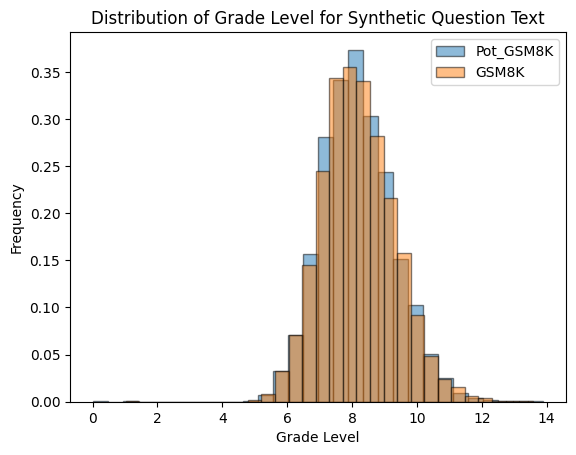

In [121]:
import matplotlib.pyplot as plt
# Create a histogram
plt.hist(pot_gsm8k_read[1], bins=30, alpha=0.5, label='Pot_GSM8K', edgecolor='black', density = True)
plt.hist(gsm8k_read[1], bins=30, alpha=0.5, label='GSM8K', edgecolor='black', density = True)

# Customize the plot
plt.title('Distribution of Grade Level for Synthetic Question Text')
plt.xlabel('Grade Level')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

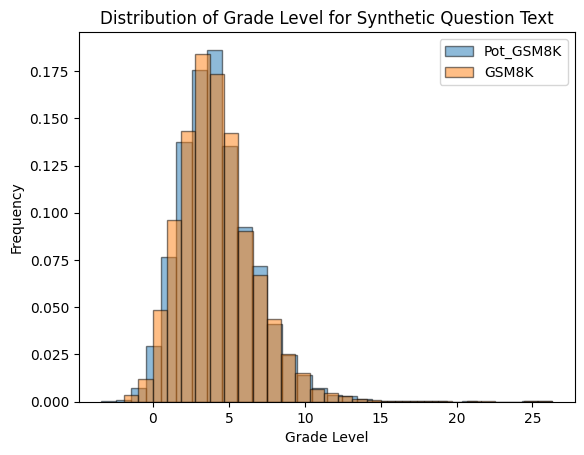

In [122]:
import matplotlib.pyplot as plt
# Create a histogram
plt.hist(pot_gsm8k_read[0], bins=30, alpha=0.5, label='Pot_GSM8K', edgecolor='black', density = True)
plt.hist(gsm8k_read[0], bins=30, alpha=0.5, label='GSM8K', edgecolor='black', density = True)

# Customize the plot
plt.title('Distribution of Grade Level for Synthetic Question Text')
plt.xlabel('Grade Level')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

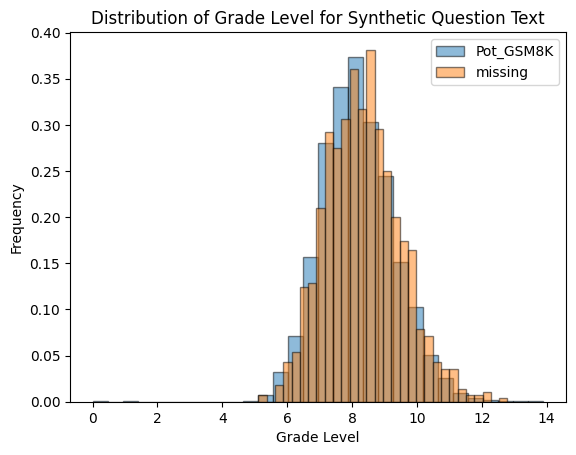

In [120]:
import matplotlib.pyplot as plt
# Create a histogram
plt.hist(pot_gsm8k_read[1], bins=30, alpha=0.5, label='Pot_GSM8K', edgecolor='black', density = True)
plt.hist(missing_read[1], bins=30, alpha=0.5, label='missing', edgecolor='black', density=True)

# Customize the plot
plt.title('Distribution of Grade Level for Synthetic Question Text')
plt.xlabel('Grade Level')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

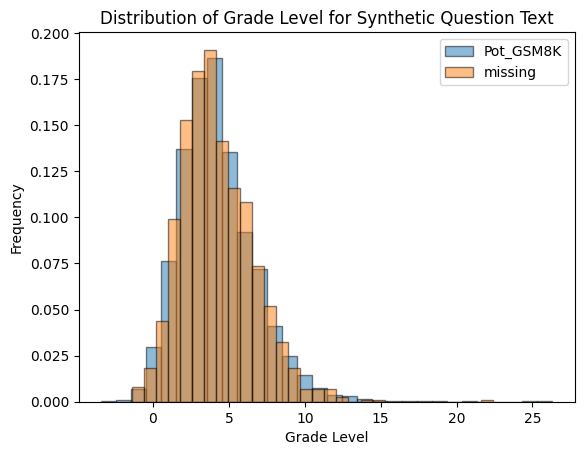

In [124]:
import matplotlib.pyplot as plt
# Create a histogram
plt.hist(pot_gsm8k_read[0], bins=30, alpha=0.5, label='Pot_GSM8K', edgecolor='black', density = True)
plt.hist(missing_read[0], bins=30, alpha=0.5, label='missing', edgecolor='black', density=True)

# Customize the plot
plt.title('Distribution of Grade Level for Synthetic Question Text')
plt.xlabel('Grade Level')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

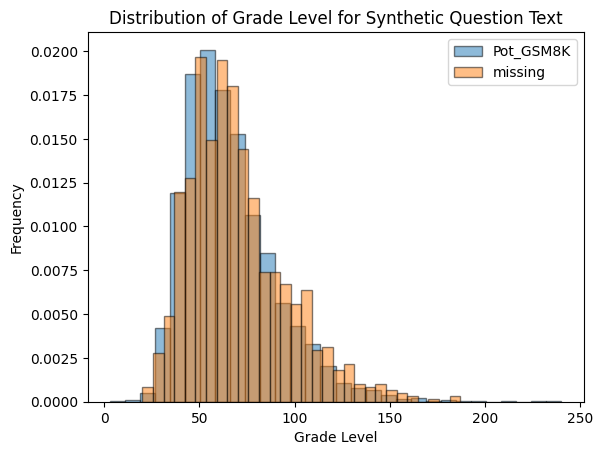

In [125]:
import matplotlib.pyplot as plt
# Create a histogram
plt.hist(pot_gsm8k_lengths, bins=30, alpha=0.5, label='Pot_GSM8K', edgecolor='black', density = True)
plt.hist(missing_lengths, bins=30, alpha=0.5, label='missing', edgecolor='black', density=True)

# Customize the plot
plt.title('Distribution of Grade Level for Synthetic Question Text')
plt.xlabel('Grade Level')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

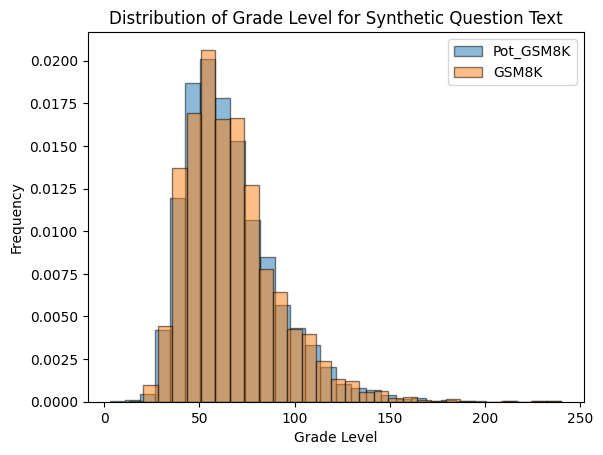

In [126]:
import matplotlib.pyplot as plt
# Create a histogram
plt.hist(pot_gsm8k_lengths, bins=30, alpha=0.5, label='Pot_GSM8K', edgecolor='black', density = True)
plt.hist(gsm8k_lengths, bins=30, alpha=0.5, label='GSM8K', edgecolor='black', density=True)

# Customize the plot
plt.title('Distribution of Grade Level for Synthetic Question Text')
plt.xlabel('Grade Level')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()